In [1]:
#%pip install -qqq python-binance pandas websocket-client sqlalchemy psycopg2-binary fastapi uvicorn matplotlib


In [2]:
import json
import websocket
import os 
from binance.client import Client
import pandas
import logging
import sys
import io
from sqlalchemy import create_engine, text

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)  
if not logger.hasHandlers():
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(logging.Formatter('%(message)s'))
    logger.addHandler(handler)

logging.info("Libraries imported successfully")

Libraries imported successfully


In [4]:
api_key = os.environ["BINANCE_API_KEY"]
api_secret = os.environ["BINANCE_SECRET"]
client = Client(api_key, api_secret, testnet=True)
symbol = "BTCUSDT"
socket = f"wss://stream.binance.com:9443/ws/{symbol.lower()}@trade"

In [5]:
user = os.environ["POSTGRE_USER"]      
password = os.environ["POSTGRE_PASS"]
host = os.environ["POSTGRE_HOST"]
port = 33547
database = "tsdb"
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

Getting near-real-time price updates via WebSocket so that we can compare them with the last cached/retrieved price information from the REST API.


In [6]:
tickers = client.get_symbol_ticker(symbol='BTCUSDT')
df_current_prices = pandas.DataFrame([tickers], columns=["symbol","price"])
df_current_prices["price"] = df_current_prices["price"].astype(float)
def on_message_single(ws, message):
    msg = json.loads(message)
    df_current_prices["websocket_price"] = float(msg['p'])
    ws.close()
    logging.info("Received message and closed connection!")
web = websocket.WebSocketApp(
    socket,
    on_message=on_message_single)

web.run_forever()
df_current_prices = df_current_prices.rename(columns={"price":"rest_api_price"})
df_current_prices.head()

Websocket connected
Received message and closed connection!


,symbol,rest_api_price,websocket_price
0,BTCUSDT,91273.99,91267.49


In [ ]:
SYMBOL = "btcusdt"
counter = 0
ticks = []

def on_message_stream(ws, message):
    global counter
    global ticks
    data = json.loads(message)
    tick = {
        "ts": pandas.to_datetime(data["T"], unit="ms", utc=True), 
        "price": float(data["p"]),
        "data_source": "websocket",
        "instrument": SYMBOL.upper()
    }
    counter += 1
    ticks.append(tick)
    if counter == 20000:
        ws.close()
        logging.info(f"Received {counter} messages, closing WebSocket")

web = websocket.WebSocketApp(
    socket,
    on_message=on_message_stream)

web.run_forever()


Websocket connected


Aggregation of data received from the WebSocket

In [171]:
df_ticks = pandas.DataFrame(ticks).sort_values("ts").set_index("ts")

df_web_socket = df_ticks.resample("1min").agg(
    highest=("price", "max"),
    lowest=("price", "min"),
    mean=("price", "mean"),
    volume=("price", "count"),
)

df_web_socket["ma_10"] = df_web_socket["mean"].rolling(10, min_periods=1).mean()
df_web_socket["ma_20"] = df_web_socket["mean"].rolling(20, min_periods=1).mean()
df_web_socket["instrument"] = SYMBOL.upper()
df_web_socket["data_source"] = "WEBSOCKET"
df_web_socket.reset_index(inplace=True)
df_web_socket = df_web_socket.rename(columns={"mean":"price"})
df_web_socket = df_web_socket[["ts","instrument","price","volume","highest","lowest","ma_10","ma_20","data_source"]]
df_web_socket.tail()


,ts,instrument,price,volume,highest,lowest,ma_10,ma_20,data_source
3,2026-01-08 20:32:00+00:00,BTCUSDT,90613.646446,3756,90643.65,90590.77,90633.451602,90633.451602,WEBSOCKET
4,2026-01-08 20:33:00+00:00,BTCUSDT,90640.407720,1531,90652.80,90625.96,90634.842825,90634.842825,WEBSOCKET
5,2026-01-08 20:34:00+00:00,BTCUSDT,90639.557535,1420,90655.83,90625.96,90635.628610,90635.628610,WEBSOCKET
6,2026-01-08 20:35:00+00:00,BTCUSDT,90677.281943,2748,90708.26,90645.01,90641.579086,90641.579086,WEBSOCKET
7,2026-01-08 20:36:00+00:00,BTCUSDT,90709.450786,2393,90741.89,90675.52,90650.063049,90650.063049,WEBSOCKET


In [172]:
interval = Client.KLINE_INTERVAL_1MINUTE
limit = 8  #amount of minutes to get from the REST API

klines = client.get_klines(symbol=symbol, interval=interval, limit=limit)
columns = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
]

df_rest = pandas.DataFrame(klines, columns=columns)

df_rest["open_time"] = pandas.to_datetime(df_rest["open_time"], unit="ms", utc=True)
numeric_cols = ["open", "high", "low", "close", "volume"]
df_rest[numeric_cols] = df_rest[numeric_cols].astype(float)

df_rest = df_rest.set_index("open_time")
df_rest["ma_10"] = df_rest["close"].rolling(10, min_periods=1).mean()
df_rest["ma_20"] = df_rest["close"].rolling(20, min_periods=1).mean()
df_rest["instrument"] = SYMBOL.upper()
df_rest["data_source"] = "REST_API"
df_rest = df_rest[["instrument","close","volume","high","low","ma_10","ma_20","data_source"]]
df_rest.reset_index(inplace=True)
df_rest = df_rest.rename(columns={"open_time":"ts", "close":"price", "high":"highest", "low":"lowest"})
df_rest.tail()

,ts,instrument,price,volume,highest,lowest,ma_10,ma_20,data_source
3,2026-01-08 20:36:00+00:00,BTCUSDT,90713.03,1.12178,91350.00,90682.15,90671.880000,90671.880000,REST_API
4,2026-01-08 20:37:00+00:00,BTCUSDT,90741.50,3.44473,90741.51,89545.40,90685.804000,90685.804000,REST_API
5,2026-01-08 20:38:00+00:00,BTCUSDT,90789.96,2.91415,90789.96,90741.50,90703.163333,90703.163333,REST_API
6,2026-01-08 20:39:00+00:00,BTCUSDT,90788.32,2.26669,90789.97,90774.25,90715.328571,90715.328571,REST_API
7,2026-01-08 20:40:00+00:00,BTCUSDT,90847.99,1.22748,90847.99,90776.57,90731.911250,90731.911250,REST_API


In [173]:
rest_api = []
columns.extend(["data_source","instrument"])
to_extract = {"open_time","close","data_source", "instrument"}
for row in klines:
    row[0] = pandas.to_datetime(row[0], unit="ms", utc=True)
    row.extend( ['REST_API', SYMBOL.upper()])
    rest_api.append({columns[i] if columns[i] != 'open_time' else "ts": row[i] for i in range(len(row)) if columns[i] in to_extract})

Creation of comparison dataframe of the data received from REST API and WebSocket

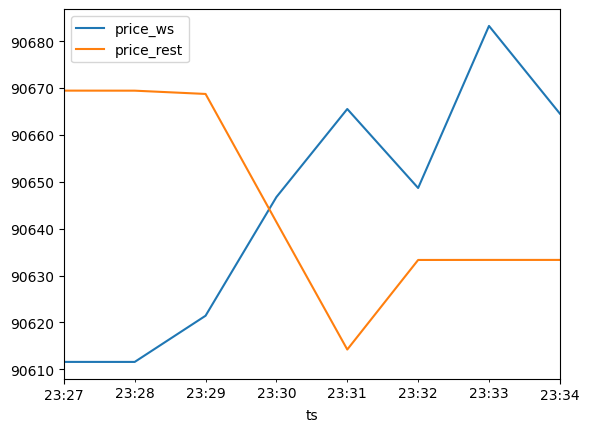

In [14]:
compare_df = df_web_socket.join(
    df_rest[["price","highest", "lowest", "ma_10", "ma_20"]],
    how="inner",
    lsuffix="_ws",
    rsuffix="_rest"
)
try:
    compare_df.plot(y=["price_ws","price_rest"], x= "ts")
except NameError:
    logging.info("Plotting skipped due to NameError")

In [191]:
def write_to_db(df, table_name):
    df.to_sql(
        table_name,
        engine,
        if_exists="append",
        index=False,
        chunk_size=BATCH_SIZE,
        schema="multi"
    )
logging.info(f"Use this methodology only for medium size dataframes (up to the millions of rows maybe), for larger datasets use the copy approach demonstrated earlier.")


Use this methodology only for medium size dataframes (up to the millions of rows maybe), for larger datasets use the copy approach demonstrated earlier.


In [ ]:

BATCH_SIZE = 100_000

def flush(buf, cursor, conn):
    buf.seek(0)
    #copy from in-=memory file to staging table
    cursor.copy_from(
        buf,
        sep=",",
        columns=("ts", "price", "instrument", "data_source"),
        table="trades_stage"
    )
    #insert new records from staging to main table
    cursor.execute("""
    INSERT INTO trades (ts, price, instrument, data_source)
    SELECT s.ts, s.price, s.instrument, s.data_source
    FROM trades_stage s
    ON CONFLICT (ts, instrument, data_source) DO NOTHING;
    """)
    cursor.execute("TRUNCATE TABLE trades_stage;")
    conn.commit()
    buf.seek(0)
    buf.truncate(0)

In [ ]:
def write_to_db(source,engine, batch_size=BATCH_SIZE):
    row_count = 0
    buf = io.StringIO()
    conn = engine.raw_connection()
    cursor = conn.cursor()
    data_source = source[0].get('data_source') if source else 'UNKNOWN'
    for row in source:
        ts = row.get('ts')
        price = row.get('price') if row.get('price') is not None else row.get('close')
        instrument = row.get('instrument')
        data_source = row.get('data_source').upper()

        buf.write(f"{ts},{price},{instrument},{data_source}\n")
        row_count += 1

        if row_count >= BATCH_SIZE:
            flush(buf, cursor, conn)
            buf = io.StringIO()
            row_count = 0
    #flush any remaining rows
    if row_count > 0:
        flush(buf, cursor, conn)
        buf = io.StringIO()
        row_count = 0
    buf.close()
    cursor.close()
    conn.close()
    logging.info(f"{data_source.upper()} data written successfully to database!")
write_to_db(ticks,engine)  # websocket
write_to_db(rest_api,engine)  # REST API


WEBSOCKET data written successfully to database!
REST_API data written successfully to database!


In [205]:
def refresh_materialized_views(engine, view_name="candles_1m_ma"):
    with engine.connect() as connection:
        connection.execute(text(f"REFRESH MATERIALIZED VIEW {view_name};"))
        connection.commit()
        logging.info(f"Materialized view '{view_name}' refreshed successfully.")
        
refresh_materialized_views(engine, "candles_1m_ma")

Materialized view 'candles_1m_ma' refreshed successfully.


In [206]:
query = """
SELECT *
FROM candles_1m_ma
WHERE instrument = :instrument
  AND bucket BETWEEN :start AND :end
order by bucket"""
instrument = input("Enter instrument (e.g., BTCUSDT): ").strip().upper()
start = input("Enter start datetime (YYYY-MM-DD HH:MM): ").strip()
end = input("Enter end datetime (YYYY-MM-DD HH:MM): ").strip()
df = pandas.read_sql(
    text(query),
    engine,
    params={
        "instrument": instrument,
        "start": start,
        "end": end
    }
)

df.head()

,bucket,instrument,data_source,open,high,low,close,avg_price,volume,ma_10,ma_20
0,2026-01-08 20:29:00+00:00,BTCUSDT,websocket,90620.78,90620.78,90593.24,90593.25,90606.378269,104,91253.366827,91203.378108
1,2026-01-08 20:29:00+00:00,BTCUSDT,WEBSOCKET,90620.78,90620.78,90593.24,90593.25,90606.378269,104,91203.362654,91178.343616
2,2026-01-08 20:30:00+00:00,BTCUSDT,websocket,90593.25,90679.64,90593.25,90679.63,90659.396500,360,91133.363304,91154.438530
3,2026-01-08 20:30:00+00:00,BTCUSDT,WEBSOCKET,90593.25,90679.64,90593.25,90679.63,90659.396500,360,91063.418954,91129.640477
4,2026-01-08 20:31:00+00:00,BTCUSDT,websocket,90679.64,90681.88,90640.14,90643.64,90663.144643,252,90992.724418,91103.753209
